In [3]:
# Re-import necessary libraries
import cv2
import numpy as np
import pandas as pd
from PIL import Image

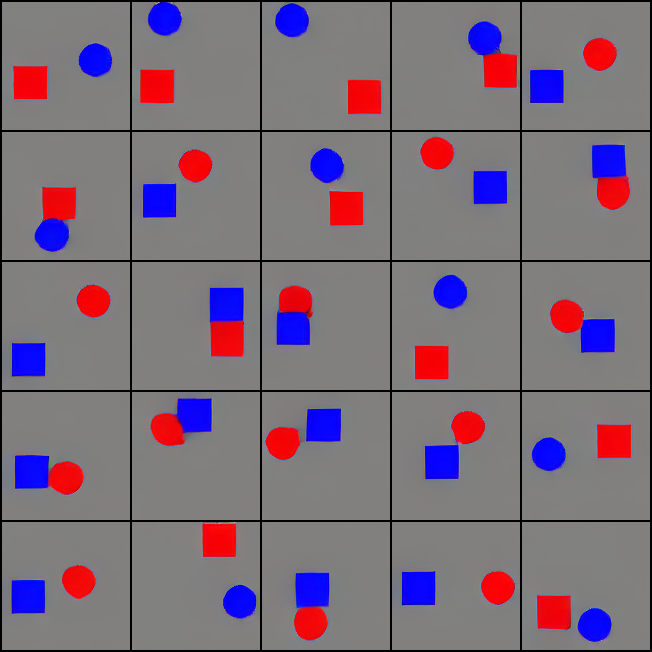

In [4]:
# Load the local image
prompt_names = [
    "blue_circle_is_above_and_to_the_right_of_blue_square",
    "blue_circle_is_above_blue_square",
    "blue_square_is_to_the_right_of_red_circle",
    "blue_triangle_is_above_red_triangle",
    "blue_triangle_is_to_the_upper_left_of_red_square",
    "circle_is_below_red_square",
    "red_circle_is_above_square",
    "red_circle_is_to_the_left_of_blue_square",
    "red_is_above_blue",
    "red_is_to_the_left_of_red",
    "triangle_is_above_and_to_the_right_of_square",
    "triangle_is_above_red_circle",
    "triangle_is_to_the_left_of_square",
    "triangle_is_to_the_left_of_triangle",
    "triangle_is_to_the_upper_left_of_square",
]

sample_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/samples"
def split_image_into_grid(image, grid_size=5, cell_size=128, padding=2):
    """
    Split an image into a grid of subimages.
    
    Args:
        image: PIL Image to split
        grid_size: Size of grid (grid_size x grid_size)
        cell_size: Width/height of each cell in pixels
        padding: Padding between cells in pixels
        
    Returns:
        List of subimages as PIL Images
    """
    width, height = image.size
    cell_width = cell_size
    cell_height = cell_size
    
    # Verify image dimensions match expected grid
    assert (cell_width + padding) * grid_size + padding == width and \
        (cell_height + padding) * grid_size + padding == height
        
    subimages = []
    for row in range(grid_size):
        for col in range(grid_size):
            left = col * (cell_width + padding) + padding
            upper = row * (cell_height + padding) + padding
            right = left + cell_width
            lower = upper + cell_height
            subimages.append(image.crop((left, upper, right, lower)))
            
    return subimages


def load_image(step_num, prompt_id, sample_root=sample_root):
    image_path = f"{sample_root}/step_{step_num}_sample_{prompt_names[prompt_id]}.png"
    image = Image.open(image_path)
    return image


def load_image_grid(step_num, prompt_id, sample_root=sample_root):
    image = load_image(step_num, prompt_id, sample_root)
    return split_image_into_grid(image)


prompt_id = 2
step_num = 10000
image_path = f"{sample_root}/step_{step_num}_sample_{prompt_names[prompt_id]}.png"
image = Image.open(image_path)
image

In [44]:
def find_classify_objects(image, area_threshold=100, radius=16.0):
    if isinstance(image, Image.Image):
        image = np.array(image)
    # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    classified_objects = []
    for channel in range(3):
        gray_image = image[:,:,channel]
        # Threshold the image to create a binary mask
        _, binary_mask = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY)
        # Find contours of the shapes
        contours, _ = cv2.findContours(binary_mask, 
                                    cv2.RETR_EXTERNAL, 
                                    cv2.CHAIN_APPROX_SIMPLE)
        # Initialize results
        for i, contour in enumerate(contours):
            # Calculate properties of the contour
            approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
            area = cv2.contourArea(contour)
            x, y, w, h = cv2.boundingRect(contour)
            # Shape classification based on the number of vertices
            if len(approx) == 3:
                shape = "Triangle"
                s = radius * 2  # Side length
                h = s * (3 ** 0.5) / 2  # Height of the equilateral triangle
                expected_area = s * h / 2
            elif len(approx) == 4:
                shape = "Square" if abs(w - h) < 5 else "Rectangle"
                s = radius * 2
                expected_area = s**2
            elif len(approx) > 4:
                shape = "Circle"
                expected_area = np.pi * radius ** 2
            else:
                shape = "Unknown"
            # Calculate the color of the shape by extracting the region
            mask = np.zeros_like(gray_image)
            cv2.drawContours(mask, [contour], -1, 255, -1)
            mean_color = cv2.mean(image, mask=mask)
            # Add to results
            if area < area_threshold:
                continue
            classified_objects.append({
                "Object": i + 1,
                "Shape": shape,
                "Color (RGB)": tuple(map(int, mean_color[:3])),
                "Center (x, y)": (x + w // 2, y + h // 2),
                "Area": area,
                "Expected Area": expected_area
            })

    # Convert to DataFrame for better visualization
    classified_objects_df = pd.DataFrame(classified_objects)
    classified_objects_df
    return classified_objects_df
# Display the classification results to the user
# import ace_tools as tools; tools.display_dataframe_to_user(name="Shape and Color Classification Results", dataframe=classified_objects_df)


red_is_above_blue


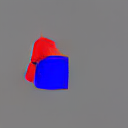

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       2  Circle  (220, 25, 34)      (46, 58)  575.0     804.247719
1       4  Circle   (15, 5, 241)      (51, 73)  993.5     804.247719


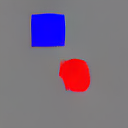

   Object   Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (239, 14, 20)      (75, 75)   842.0         1024.0
1       5  Square   (16, 7, 246)      (48, 30)  1082.5         1024.0


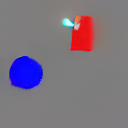

   Object      Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       4  Rectangle  (222, 41, 41)      (82, 33)  717.5    1024.000000
1       1     Circle  (18, 13, 241)      (26, 72)  863.5     804.247719


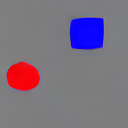

   Object   Shape   Color (RGB) Center (x, y)   Area  Expected Area
0       1  Circle  (240, 9, 18)      (23, 76)  730.0     804.247719
1       9  Square  (15, 9, 246)      (86, 33)  990.0    1024.000000


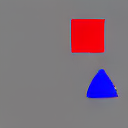

   Object     Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       3    Square   (240, 4, 14)      (88, 36)  1080.0    1024.000000
1       1  Triangle  (19, 13, 240)   (102, 82.0)   588.0     443.405007


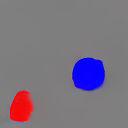

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Circle  (235, 22, 24)     (22, 106)  563.5     804.247719
1      10  Circle   (15, 8, 244)      (88, 74)  882.0     804.247719


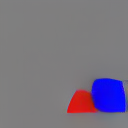

   Object      Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1  Rectangle  (200, 30, 26)     (82, 101)   460.5         1024.0
1       2     Square  (19, 13, 235)     (109, 95)  1000.0         1024.0


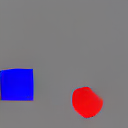

   Object   Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1  Circle  (231, 18, 24)     (88, 102)   695.5     804.247719
1       5  Square   (16, 7, 239)      (17, 84)  1006.0    1024.000000


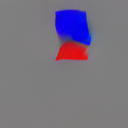

   Object      Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Rectangle  (206, 26, 31)      (71, 52)  413.5         1024.0
1       4     Square  (18, 13, 223)      (74, 27)  958.0         1024.0


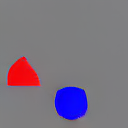

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Square  (237, 15, 21)      (24, 71)  656.0         1024.0
1       1  Square   (17, 9, 243)     (71, 103)  881.5         1024.0


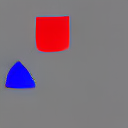

   Object   Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square   (238, 6, 16)      (53, 34)  1106.0         1024.0
1       1  Square  (20, 12, 240)      (20, 75)   539.0         1024.0


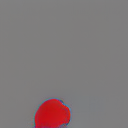

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Circle  (189, 24, 33)     (53, 113)  745.5     804.247719


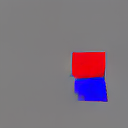

   Object      Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       4  Rectangle   (229, 4, 18)      (89, 64)  789.0         1024.0
1       1  Rectangle  (24, 10, 237)      (90, 90)  662.0         1024.0


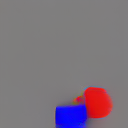

   Object      Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1     Circle  (213, 31, 33)     (93, 102)  711.5     804.247719
1       2  Rectangle  (21, 12, 234)     (71, 116)  639.0    1024.000000


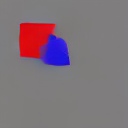

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Square  (214, 14, 22)      (37, 40)  894.0         1024.0
1       1  Square  (46, 28, 209)      (54, 50)  609.5         1024.0


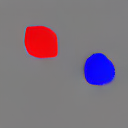

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       2  Square  (235, 10, 18)      (41, 42)  891.5    1024.000000
1       5  Circle  (18, 12, 241)     (100, 69)  770.5     804.247719


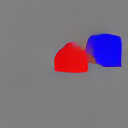

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       3  Circle  (217, 20, 25)      (72, 57)  846.0     804.247719
1       5  Circle  (27, 14, 229)     (104, 50)  951.5     804.247719


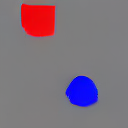

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       3  Square  (236, 12, 18)      (38, 20)  981.0    1024.000000
1       1  Circle  (18, 16, 240)      (82, 91)  758.5     804.247719


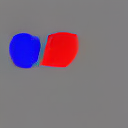

   Object   Shape    Color (RGB) Center (x, y)    Area  Expected Area
0       1  Circle  (232, 16, 21)      (59, 50)  1025.5     804.247719
1       7  Circle  (24, 20, 230)      (25, 50)   903.5     804.247719


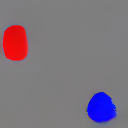

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       5  Circle  (229, 18, 20)      (15, 43)  740.5     804.247719
1       1  Circle  (16, 14, 240)    (102, 107)  657.0     804.247719


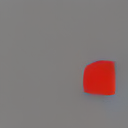

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Square  (194, 35, 26)      (99, 77)  949.5         1024.0


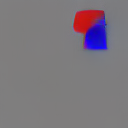

   Object      Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Rectangle  (188, 26, 31)      (88, 22)  401.5         1024.0
1       2  Rectangle  (38, 16, 197)      (96, 35)  482.0         1024.0


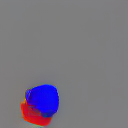

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Circle  (190, 30, 37)     (35, 112)  313.5     804.247719
1       2  Circle  (26, 11, 225)     (42, 100)  721.5     804.247719


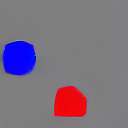

   Object   Shape    Color (RGB) Center (x, y)   Area  Expected Area
0       1  Circle  (235, 11, 17)     (70, 101)  838.0     804.247719
1      10  Square   (14, 9, 243)      (19, 58)  953.5    1024.000000


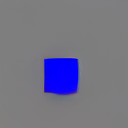

   Object   Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Square  (10, 6, 243)      (61, 76)  1171.0         1024.0


In [52]:
# image = load_image(step_num, prompt_id)
# display(image)
step_num = 2500
prompt_id = 8
subimages = load_image_grid(step_num, prompt_id)
print(prompt_names[prompt_id])
for subimage in subimages:
    display(subimage)
    classified_objects_df = find_classify_objects(subimage)
    print(classified_objects_df)


In [30]:

subimages = load_image_grid(step_num, prompt_id)
# Reload the image
# image_path = "/mnt/data/35770291-C7B3-46DC-B609-516FE6349F33.png

image = np.array(subimages[0]) #cv2.imread(image_path)
# gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
classified_objects = []
for channel in range(3):
    gray_image = image[:,:,channel]
    # Threshold the image to create a binary mask
    _, binary_mask = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)

    # Find contours of the shapes
    contours, _ = cv2.findContours(binary_mask, 
                                cv2.RETR_EXTERNAL, 
                                cv2.CHAIN_APPROX_SIMPLE)

    # Initialize results
    for i, contour in enumerate(contours):
        # Calculate properties of the contour
        approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        # Shape classification based on the number of vertices
        if len(approx) == 3:
            shape = "Triangle"
        elif len(approx) == 4:
            shape = "Square" if abs(w - h) < 5 else "Rectangle"
        elif len(approx) > 4:
            shape = "Circle"
        else:
            shape = "Unknown"
        # Calculate the color of the shape by extracting the region
        mask = np.zeros_like(gray_image)
        cv2.drawContours(mask, [contour], -1, 255, -1)
        mean_color = cv2.mean(image, mask=mask)
        # Add to results
        classified_objects.append({
            "Object": i + 1,
            "Shape": shape,
            "Color (RGB)": tuple(map(int, mean_color[:3])),
            "Center (x, y)": (x + w // 2, y + h // 2),
            "Area": area
            
        })

# Convert to DataFrame for better visualization
classified_objects_df = pd.DataFrame(classified_objects)
classified_objects_df
# Display the classification results to the user
# import ace_tools as tools; tools.display_dataframe_to_user(name="Shape and Color Classification Results", dataframe=classified_objects_df)

,Object,Shape,Color (RGB),"Center (x, y)",Area
0,1,Square,"(246, 1, 8)","(28, 80)",1010.0
1,1,Circle,"(5, 5, 252)","(93, 58)",790.5


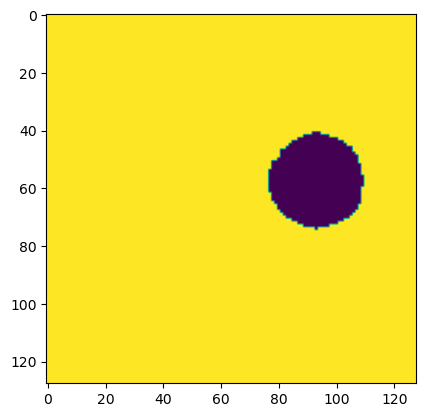

In [25]:
import matplotlib.pyplot as plt
plt.imshow(binary_mask)

,Object,Shape,Color (RGB),"Center (x, y)"
0,1,Square,"(129, 112, 126)","(64, 64)"
